In [27]:
##Run the below block to initialize all the dependencies
import requests
from pprint import pprint
import pandas as pd
from pandas import ExcelWriter
import io, time, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy
import warnings
import io, time, json
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srossgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
##The below block of code is used to read the API Key required for extracting data from Yelp fusion API.

def read_api_key(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open('api_key.txt', 'r') as f:
        return f.read().replace('\n','')

def read_api_key_zomato(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open('api_key_zomato.txt', 'r') as f:
        return f.read().replace('\n','')

In [ ]:
##The function below is used to retrieve all the restaurants from the YELP API.

def all_restaurants(api_key, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """
    
    offsetno=0
    total =0
    output=[]
    headers = {        
        "authorization": 'Bearer %s' % api_key, # for the yelp API     
    }
    while (offsetno < 1000):
        params = { #parameters are case sensitive!
            "location": query,
            "limit": 20,
            "offset": offsetno,
            "categories": "restaurants"
            
        }
    
        response = requests.get('https://api.yelp.com/v3/businesses/search',
                            headers=headers, params=params)
        result = response.json()
        try:
            output.append( result['businesses'])
        except KeyError:
            print(result)
            return output
        offsetno =offsetno + 20
        total = result['total']
        #print (offsetno)
        #print (len(output))
    return(output)

api_key = read_api_key('api_key.txt')
data = all_restaurants(api_key, 'Miami')
new_data = {}
new_data["name"]=[]
new_data["rating"]=[]
new_data["price"]=[]
new_data["review_count"]=[]
new_data["url"]=[]
new_data["category"]=[]
new_data["zip"]=[]
alldata=[]
ids=[]
name=[]
zips=[]
for i in data:
    for each in i:
        new_data["name"].append(each["name"])
        new_data["rating"].append(each["rating"])
        new_data["url"].append(each["url"])
        try:
            new_data["price"].append(each["price"])
        except KeyError:
            new_data["price"].append(None)

        new_data["review_count"].append(each["review_count"])
        new_data["category"].append(each["categories"][0]["title"])
        new_data["zip"].append(each["location"]["zip_code"])
        ids.append(each["id"])
        name.append(each["name"])
        zips.append(each["location"]["zip_code"])
        alldata.append(each)
writer = pd.ExcelWriter('../DataFiles/Final_Data.xlsx' , engine='xlsxwriter')
yelp_raw = pd.DataFrame(alldata)
yelp_clean = pd.DataFrame(new_data)

In [ ]:
def get_reviews(ids,name):
    headers = {        
        "authorization": 'Bearer %s' % api_key, # for the yelp API     
    }
    restau_names=[]
    output=[]
    for i in range(len(ids)):
        params = { #parameters are case sensitive!
            "locale": "en_US",
        }
        url = "https://api.yelp.com/v3/businesses/"+str(ids[i])+"/reviews"
        response = requests.get(url,
                            headers=headers,params=params)
        result = response.json()
        output.append(result["reviews"])
        restau_names.append(name[i])
    return output,restau_names
reviews, restau_name= get_reviews(ids,name)

In [ ]:
restau=[]
text_reviews=[]
loc_zip=[]
for i in range(len(reviews)):
    for each in output[i]["reviews"]:
        text_reviews.append(each["text"])
#         print(i)
        restau.append(name[i])
        loc_zip.append(zips[i])
d = {'restau_name':restau,'zip':loc_zip,'reviews':text_reviews}
reviews_df = pd.DataFrame(d)
reviews_df.to_csv("../DataFiles/reviews_df.csv",index=False)

In [4]:
#check the price  
def price(df):
    try:
        df["price"]= len(df["price"])
    except:
        df["price"]=""
    return df
yelp_clean= yelp_clean.apply(price,axis=1)

In [5]:
##The below code needs to be executed to clean the TripAdvisor CSV file and create a raw and clean dataset out of it.

trip_advisor_raw = pd.read_csv('../DataFiles/TripAdvisor_Data.csv')
trip_advisor_clean = trip_advisor_raw[trip_advisor_raw["City"]=="Miami"]
trip_advisor_clean = trip_advisor_clean.loc[:,["Restaurant ID", "Restaurant URL","Name","Address","Ranking","Total Review"]]
trip_advisor_clean['Source'] = 'Trip Advisor'

In [6]:
##Below block of code is used to extract the data from the Zomato API.

api_key_zomato = read_api_key_zomato('api_key_zomato.txt')

headers = {'Content-Type': 'application/json', 'user-key': api_key_zomato}
offset = 0
restaurantNameList = []
ratingList = []
ratingTextList = []
votesList = []
totalData = []
urlList = []
addressList = []
sourceList = []
while offset < 100:
    url = 'https://developers.zomato.com/api/v2.1/search?entity_id=291&entity_type=city&start='+str(offset)+'&count=20'
    Response = requests.get(url , headers=headers)
    offset += 20
    Response_Json = Response.json()
    Array_length = Response_Json['restaurants']
    for i in range(len(Array_length)):
        totalData.append(Response_Json['restaurants'][i])
        restaurantNameList.append(Response_Json['restaurants'][i]['restaurant']['name'])
        ratingList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['aggregate_rating'])
        ratingTextList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['rating_text'])
        votesList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['votes'])
        urlList.append(Response_Json['restaurants'][i]['restaurant']['url'])
        addressList.append(Response_Json['restaurants'][i]['restaurant']['location']['address'])
        sourceList.append('Zomato')
zomato_raw = pd.DataFrame({'AllData':totalData})
zomato_clean = pd.DataFrame({'Restaurant Name':restaurantNameList,'Rating':ratingList, 'Rating Text':ratingTextList, 'Votes':votesList, 'Url':urlList, 'Address': addressList, 'Source': sourceList})



In [7]:
##Run the below block to create the excel file with the collated data

writer = pd.ExcelWriter('../DataFiles/Final_Data.xlsx' , engine='xlsxwriter')

yelp_raw.to_excel(writer,'Yelp_Raw',index=False)
yelp_clean.to_excel(writer,'Yelp_Clean',index=False)
trip_advisor_raw.to_excel(writer, sheet_name = ' TripAdvisor_Raw')
trip_advisor_clean.to_excel(writer, sheet_name = 'TripAdvisor_Clean')
zomato_raw.to_excel(writer,sheet_name = 'Zomato_Raw')
zomato_clean.to_excel(writer,sheet_name = 'Zomato_Clean')

writer.save()
writer.close()

In [8]:
##We have to write the code for merging all the data frames.




In [9]:
##Below is the code for the visualizations.
##We read the data data sheet created above below.

data = pd.ExcelFile('../DataFiles/Final_Data.xlsx')

In [10]:
##Parsing the clean sheets below

zomato = data.parse('Zomato_Clean')
yelp = data.parse('Yelp_Clean')
ta = data.parse('TripAdvisor_Clean')

In [11]:
ta.head()
ta.shape

(1248, 7)

In [12]:
zomato.head(5)
zomato.shape

(100, 7)

In [13]:
yelp.head(5)
yelp.shape

(1000, 8)

yelp.columns

In [14]:
zomato.columns = ['address', 'rating', 'rating Text', 'name', 'url', 'votes','Source']

In [15]:
ta.columns = ['restaurantID', 'restaurantURL', 'name', 'address', 'ranking','Total Review','Source']

Cross tabulation charts

# Yelp Restaurant Category and Rating

Zomato Rating

In [16]:
bins = [ 2.5, 3, 3.5, 4.0, 4.5, 5.0]

zomato['ratingbucket'] = pd.cut(zomato['rating'], bins)

In [17]:
zomato.columns

Index(['address', 'rating', 'rating Text', 'name', 'url', 'votes', 'Source',
       'ratingbucket'],
      dtype='object')

In [18]:
zomato = zomato.sort_values('rating', ascending=False)


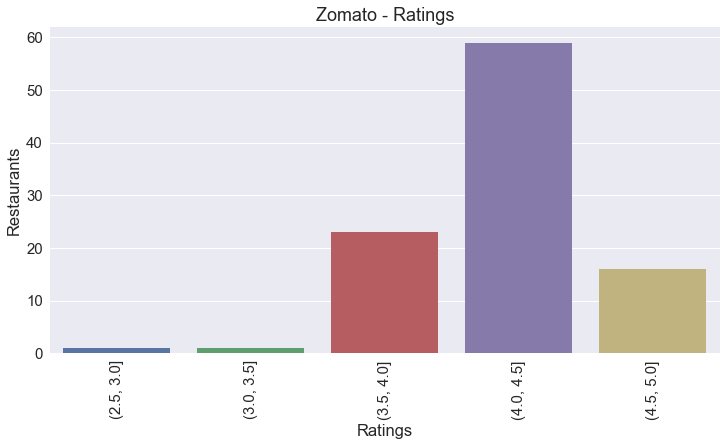

In [19]:
sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='ratingbucket', data=zomato)
plt.title('Zomato - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.xticks(rotation=90)
plt.show()

# Yelp Rating

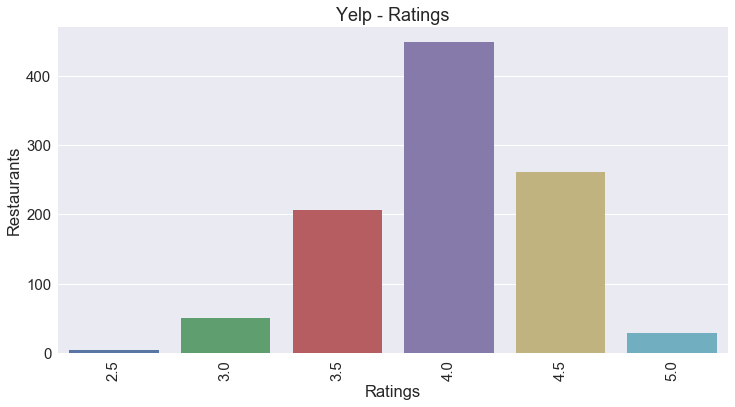

In [20]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='rating', data=yelp)
plt.title('Yelp - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.xticks(rotation=90)
plt.show()

## Yelp Price

In [64]:
yelp = yelp.sort_values('price', ascending=False)

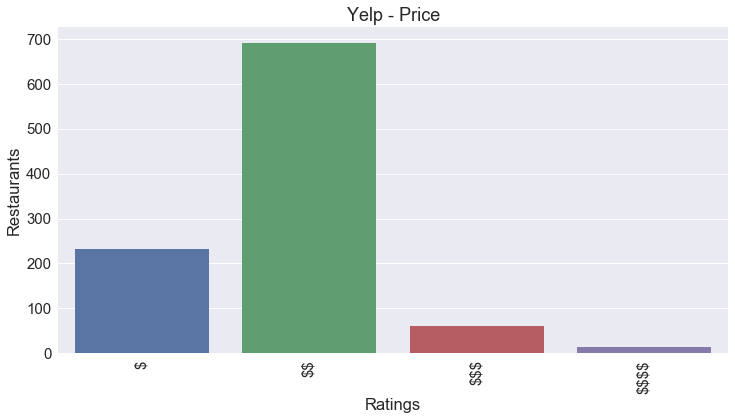

In [90]:
sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='price', data=yelp)

ax = plt.gca()

ax.set_xticklabels(['\$','\$$','\$$\$', '\$\$\$$'])
plt.title('Yelp - Price')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')

#ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.show()

## Top 20 Restaurant Categories and their Rating

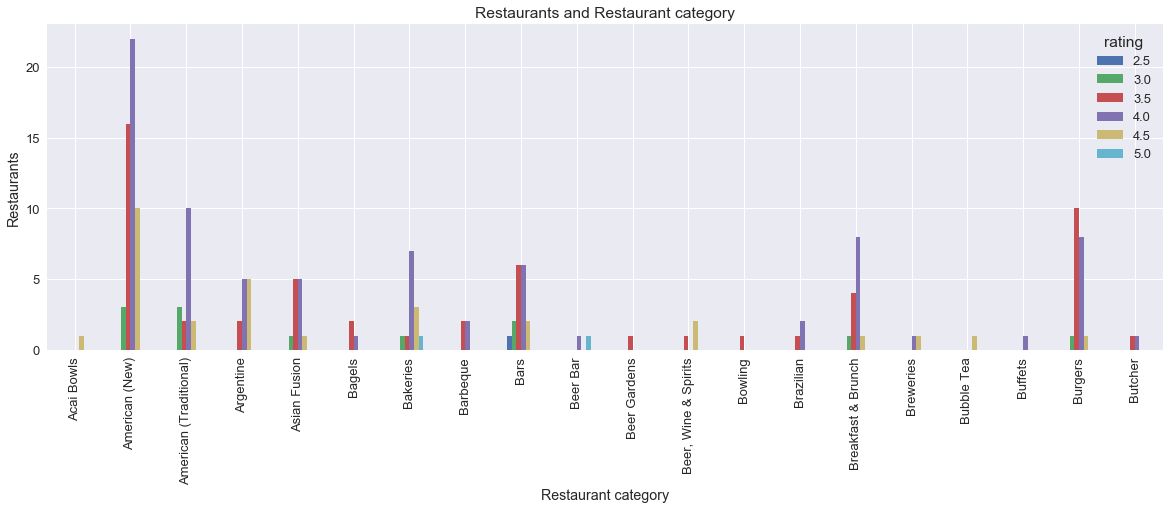

In [21]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
pd.crosstab(yelp.category,yelp.rating).head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

## Top 20 Restaurant Categories and their Price

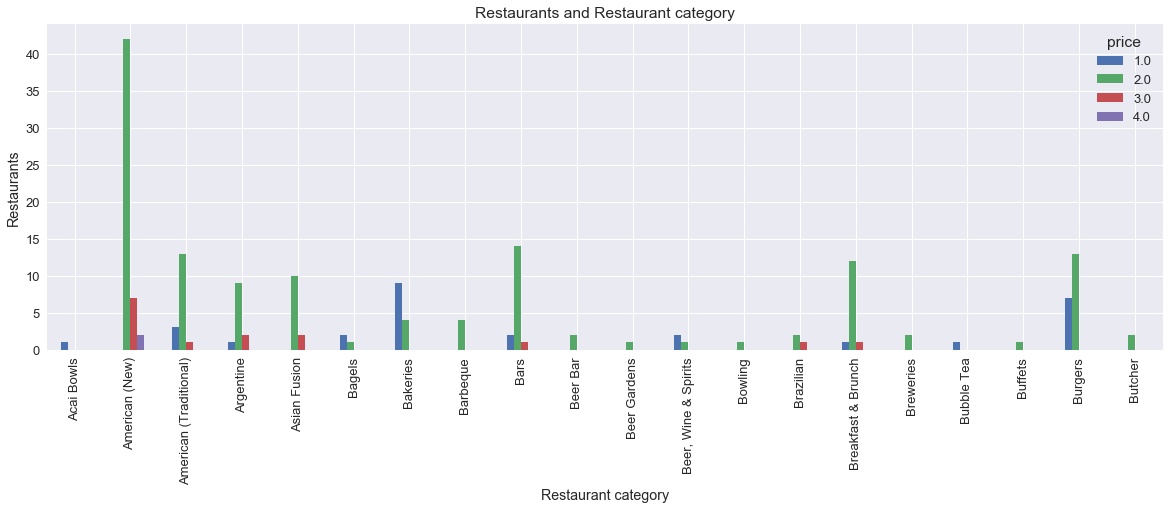

In [95]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
pd.crosstab(yelp.category,yelp.price).head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

# Trip Advisor

In [22]:
# There are in total 3600 restaurants
ta.ranking.str[-5:].unique()

array(['3,600', nan], dtype=object)

# Converting the restaurant ranking to rating

In [23]:
# Extracting the ranking for each restaurant

ta['rating'] = ta.ranking.str.split(' ').str[0].str.replace(',','')

In [24]:
# Dividing the restaurants on a scale of 3,600 total restaurants in Miami

ta['rating'] = ta['rating'].astype(float)/3600

In [25]:
# Converting to a 5-scale

ta['ratingpercentile'] = pd.qcut(ta.rating,100, labels=False)

In [26]:
ta['ratingbucket'] = np.where(ta.rating.isnull(), np.nan, 5.0)

# Top 10 percentile with rating 5
ta['ratingbucket'][ta['ratingpercentile'] > 10] = 4.5
# 10-30 percentile with 4.5
ta['ratingbucket'][ta['ratingpercentile'] > 30] = 4.0
# 30 -60 with 3.5
ta['ratingbucket'][ta['ratingpercentile'] > 60] = 3.5
# 60 - 80 with 3.0
ta['ratingbucket'][ta['ratingpercentile'] > 80] = 3.0
# 80 - 90 with 2.5
ta['ratingbucket'][ta['ratingpercentile'] > 90] = 2.5

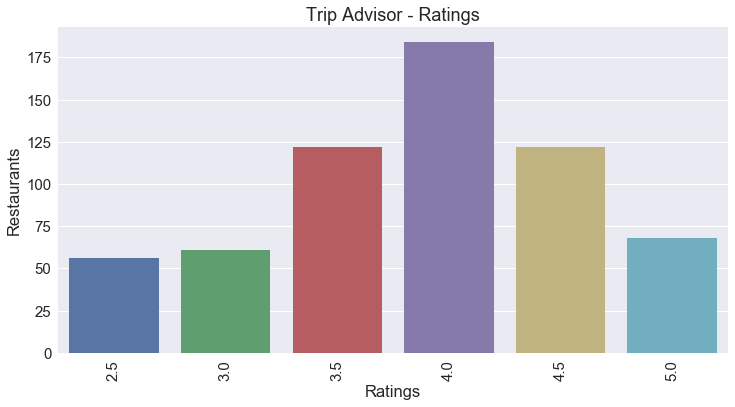

In [27]:
ta = ta.sort_values('rating', ascending=False)

sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='ratingbucket', data=ta)
plt.title('Trip Advisor - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.xticks(rotation=90)
plt.show()

In [96]:
zomato.columns

Index(['address', 'rating', 'rating Text', 'name', 'url', 'votes', 'Source',
       'ratingbucket'],
      dtype='object')

In [97]:
yelp.columns

Index(['Source', 'category', 'name', 'price', 'rating', 'review_count', 'url',
       'zip'],
      dtype='object')

In [98]:
ta.columns

Index(['restaurantID', 'restaurantURL', 'name', 'address', 'ranking',
       'Total Review', 'Source', 'rating', 'ratingpercentile', 'ratingbucket'],
      dtype='object')

In [101]:
zomato.columns = ['zomato_Address', 'zomato_rating', 'zomato_Rating Text', 'name', 'zomato_Url', 'zomato_Votes',
       'zomato_Source','zomato_ratingbucket']

In [99]:
yelp.columns = ['yelp_source','yelp_category', 'name', 'yelp_price', 'yelp_rating', 'yelp_review_count', 'yelp_url', 'yelp_zip']

In [100]:
ta.columns = ['ta_restaurantID', 'ta_restaurantURL', 'name', 'ta_address', 'ta_ranking',
       'ta_total review', 'ta_source', 'ta_rating', 'ta_ratingpercentile', 'ta_ratingbucket']

In [102]:
comb = pd.merge(ta, zomato, how = 'inner', on = 'name')

comb.shape

(3, 17)

In [103]:
comb2 = pd.merge(comb, yelp, how = 'inner', on = 'name')

comb2.shape

(4, 24)

## Rating comparison Yelp vs Ta vs Zomato

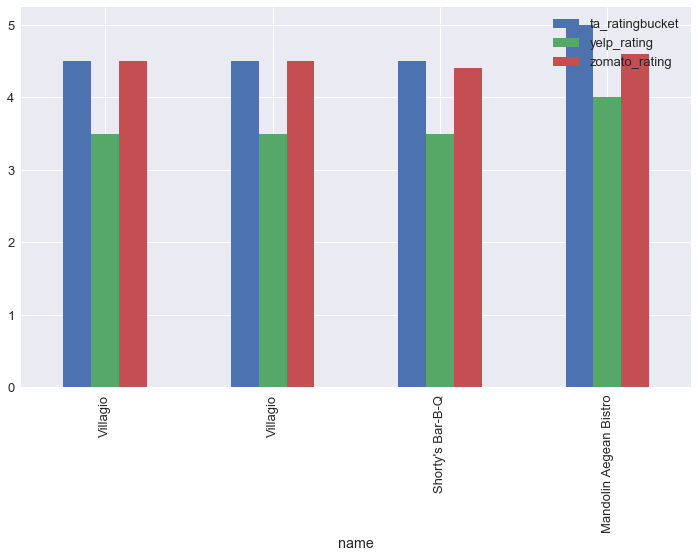

In [111]:
sns.set(font_scale=1.3)

comb2.plot(kind='bar', x = 'name',y = ['ta_ratingbucket','yelp_rating','zomato_rating'], figsize=(12,7))

plt.show()

## Rating comparison Yelp vs Zomato

In [105]:
comb3 = pd.merge(zomato, yelp, how = 'inner', on = 'name')

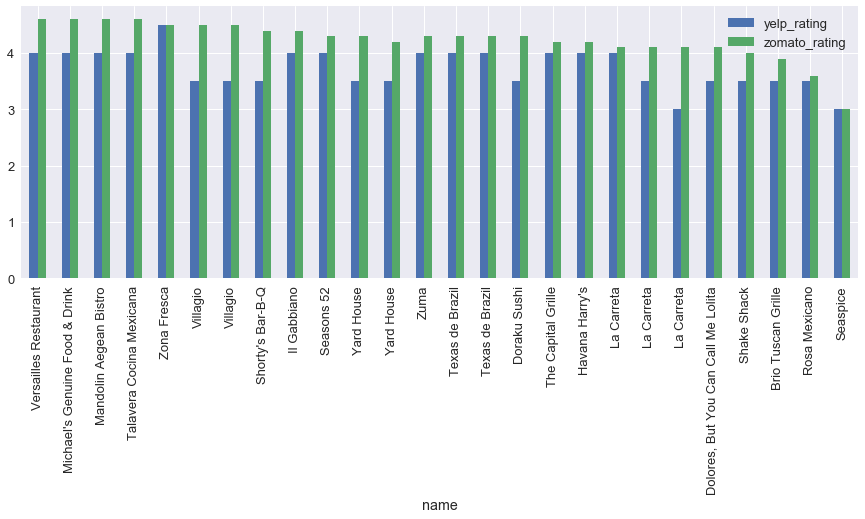

In [106]:
sns.set(font_scale=1.3)

comb3.plot(kind='bar', x = 'name',y = ['yelp_rating','zomato_rating'], figsize=(15,5))

plt.show()

## Word Cloud by Zip code

In [28]:
df_reviews= pd.read_csv("../DataFiles/reviews_df.csv")

FileNotFoundError: File b'reviews_df.csv' does not exist

In [ ]:
def datacleaning(df):
    #removing @
    df["reviews"]= df.apply(lambda row: re.sub(r'@[\w0-9]+','',row["reviews"],re.IGNORECASE), axis=1)
    #removing URL tags
    df["reviews"]= df.apply(lambda row: re.sub(r'https?://[\w0-9./]+','',row["reviews"],re.IGNORECASE), axis=1)
    df["reviews"]= df.apply(lambda row: re.sub(r'www.[^ ]+','',row["reviews"],re.IGNORECASE), axis=1)
    
    #removing Byte order marks
    df["reviews"]= df.apply(lambda row: row["reviews"].replace(u"\ufffd", "?"), axis=1)
    #Convert the data to lowercase
    df["reviews"]= df.apply(lambda row: row["reviews"].lower(), axis=1)    
    #removing hashtag/numbers and punctuations
    df["reviews"]= df.apply(lambda row: re.sub(r"[^a-zA-Z ]+",'',row["reviews"]), axis=1)
    return df
df_reviews = datacleaning(df_reviews)

In [ ]:
def handle_length(text):
    tokenizer = nltk.tokenize.word_tokenize
    words = tokenizer(text)
    fin=[]
    for word in words:
        if len(word)>1:
            fin.append(word)
    return " ".join(fin)    
df_reviews["reviews"] = df_reviews["reviews"].apply(handle_length)

In [ ]:
def filter_data_byzip(df,zip_code):
    df_ = df.copy()
    df_ = df_[df_["zip"]==zip_code]
    return " ".join(list(df_["reviews"]))

In [29]:
df_reviews["zip"].unique()

NameError: name 'df_reviews' is not defined

In [ ]:
val = int(input("Enter the Zipcode:"))

reviews_list= filter_data_byzip(df_reviews,val)
if len(reviews_list)!=0:
    wc = WordCloud(width=1600, height=800,max_font_size=200,stopwords=nltk.corpus.stopwords.words('english')\
                         , colormap="viridis").generate(reviews_list)
    plt.figure(figsize=(20,18))
    plt.imshow(wc, interpolation="bicubic")
    plt.axis("off")
    plt.show()
else:
    print("enter the zip code in the list")
    